In [1]:
!git clone https://github.com/anushka-s/Image-restoration-using-deep-image-prior.git
!mv Image-restoration-using-deep-image-prior/* ./

Cloning into 'Image-restoration-using-deep-image-prior'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [3]:
## denoising
fname = '/content/data/denoising/F16_GT.png'

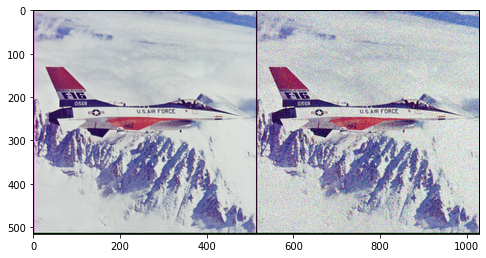

In [4]:
if fname == '/content/data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.001

OPTIMIZER= 'adam'
show_every = 100
exp_weight=0.99

if fname == '/content/data/denoising/F16_GT.png':
    num_iter = 1000
    input_depth = 3
    figsize = 3 
    
   
    net = Hourglass().to(device)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach().to(device)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype).to(device)

Number of params: 1786545


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.




After 0 iterations: 
Iteration 00000    Loss 0.126038   PSNR_noisy: 8.994994   PSRN_gt: 9.293585   PSNR_gt_sm: 9.293585 


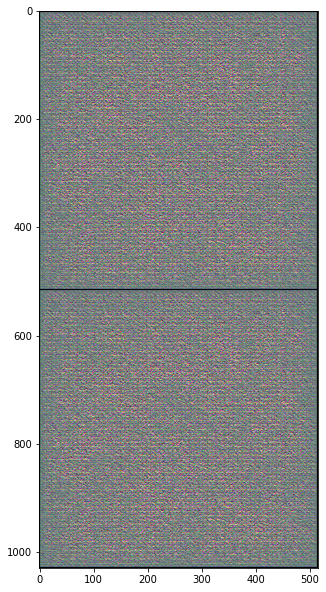



After 100 iterations: 
Iteration 00100    Loss 0.054161   PSNR_noisy: 12.663171   PSRN_gt: 13.423495   PSNR_gt_sm: 11.674338 


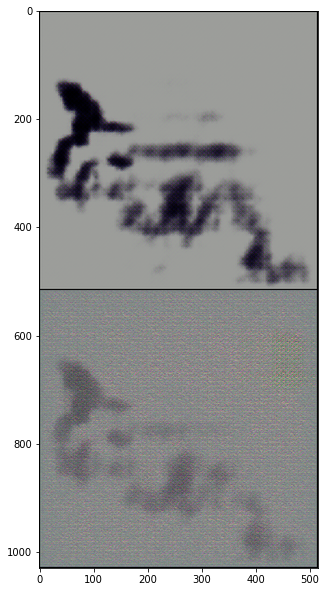



After 200 iterations: 
Iteration 00200    Loss 0.037440   PSNR_noisy: 14.266656   PSRN_gt: 15.421895   PSNR_gt_sm: 13.910257 


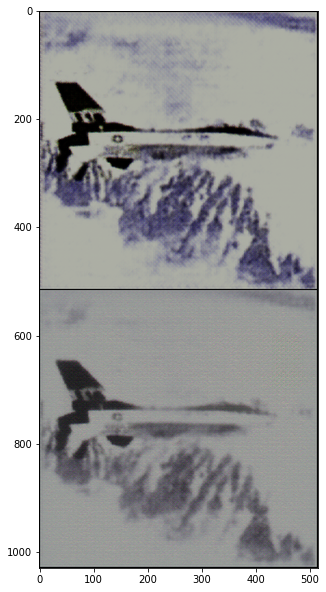



After 300 iterations: 
Iteration 00300    Loss 0.029038   PSNR_noisy: 15.370275   PSRN_gt: 16.912626   PSNR_gt_sm: 15.600089 


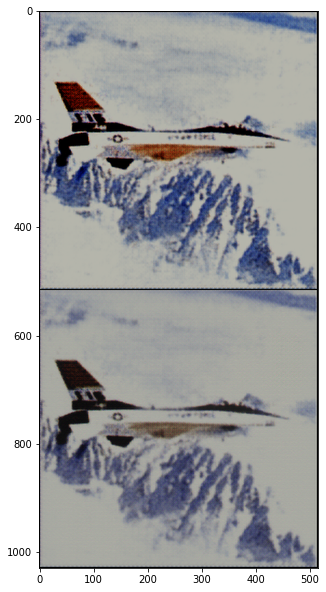



After 400 iterations: 
Iteration 00400    Loss 0.023632   PSNR_noisy: 16.265007   PSRN_gt: 18.232227   PSNR_gt_sm: 17.029290 


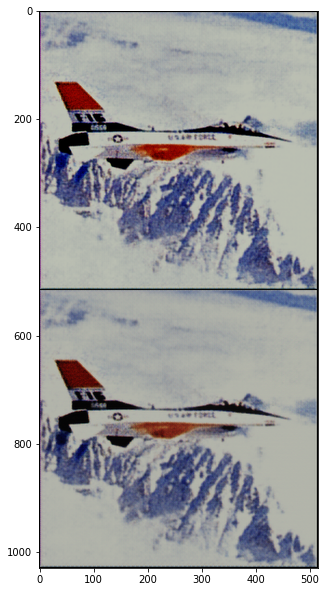



After 500 iterations: 
Iteration 00500    Loss 0.019980   PSNR_noisy: 16.994085   PSRN_gt: 19.419613   PSNR_gt_sm: 18.279076 


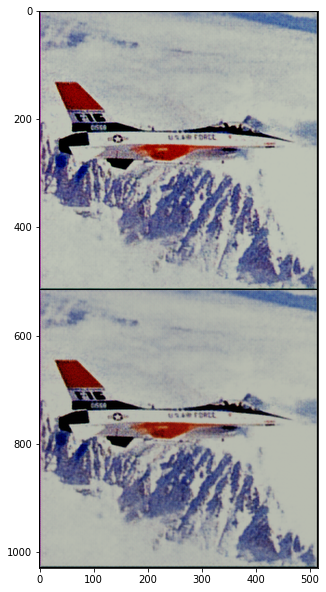



After 600 iterations: 
Iteration 00600    Loss 0.017407   PSNR_noisy: 17.592780   PSRN_gt: 20.498748   PSNR_gt_sm: 19.432075 


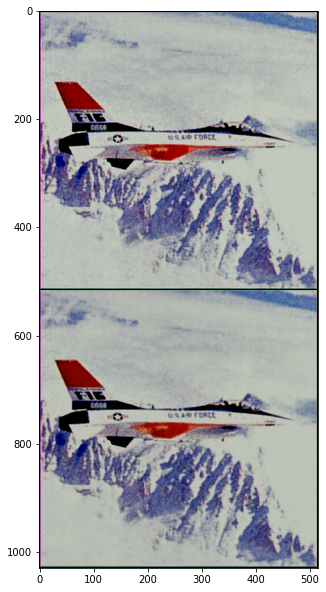



After 700 iterations: 
Iteration 00700    Loss 0.015550   PSNR_noisy: 18.082690   PSRN_gt: 21.483829   PSNR_gt_sm: 20.508891 


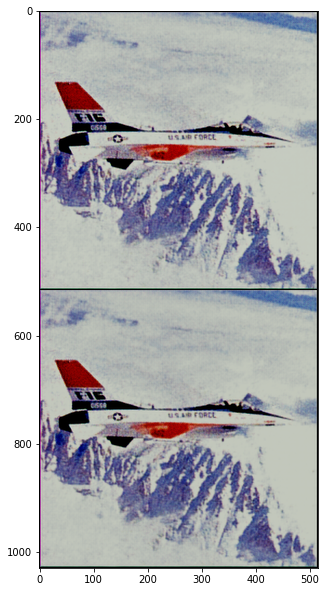



After 800 iterations: 
Iteration 00800    Loss 0.014172   PSNR_noisy: 18.485833   PSRN_gt: 22.378122   PSNR_gt_sm: 21.510039 


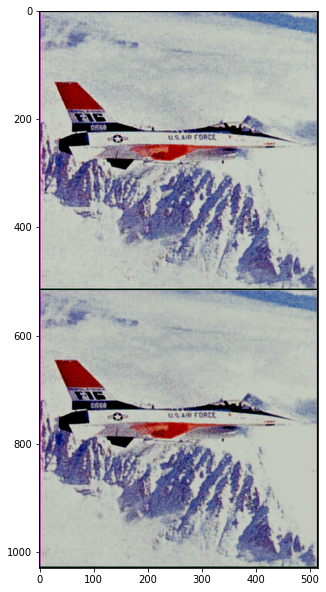



After 900 iterations: 
Iteration 00900    Loss 0.013150   PSNR_noisy: 18.810606   PSRN_gt: 23.170799   PSNR_gt_sm: 22.419566 


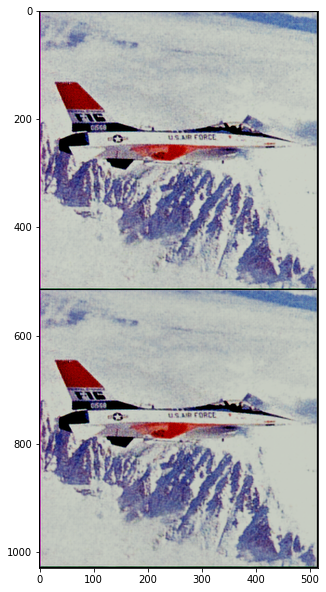

In [11]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
loss = []

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, loss
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std) #changing the input to the netwok
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight) # calculating average network output
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    loss.append(total_loss.item())
        
    
    # caculating psrn
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) # comparing psnr for the output image and the actual noisy image 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) # comparing psnr for the output image and the original image 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) # comparing psnr for the output average and the original image 
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        # plotting the output image along the average image calculated
        print(f'\n\nAfter {i} iterations: ')
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f   PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='\n')
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

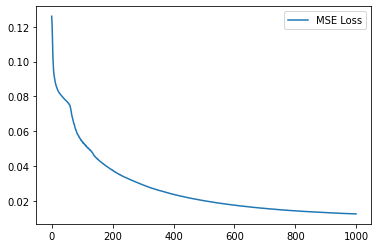

In [12]:
# Plotting the loss as a function of number of iterations
itr = [i for i in range(num_iter)]
plt.plot(itr, loss, )
plt.legend(['MSE Loss'])
plt.show()

Output Image from the network: 


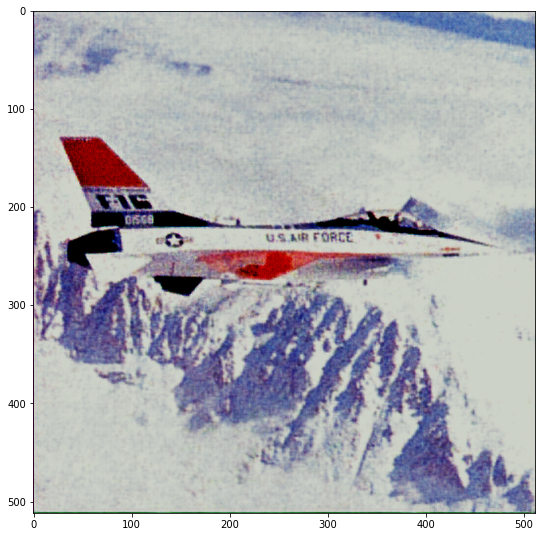


Noised Image: 


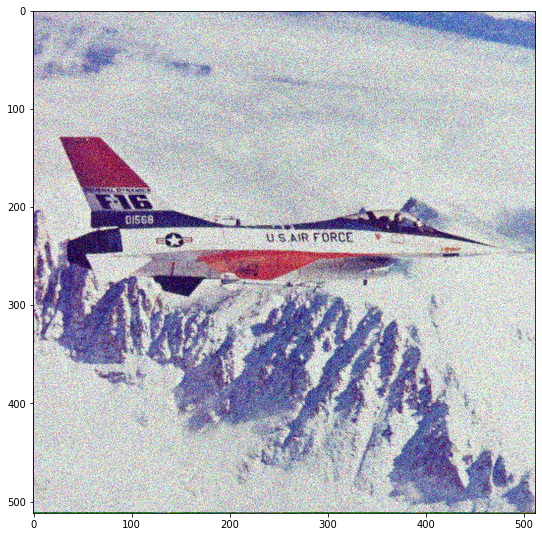


Original Image: 


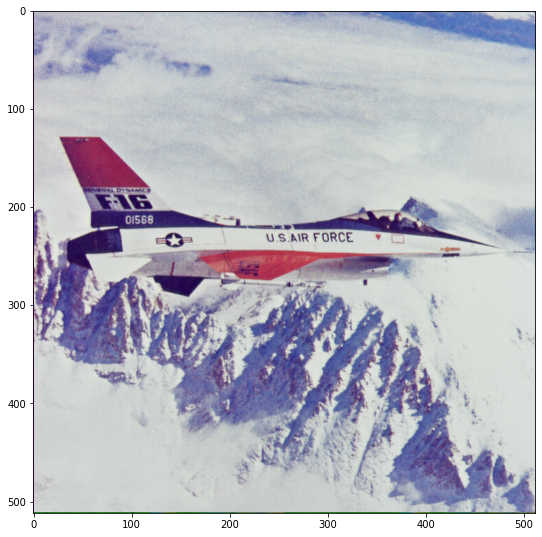

In [13]:
out_np = torch_to_np(net(net_input))

print('Output Image from the network: ')
plot_image_grid([np.clip(out_np, 0, 1)], factor=8);

print('\nNoised Image: ')
plot_image_grid([img_noisy_np], factor=8);

print('\nOriginal Image: ')
plot_image_grid([img_np], factor=8);

In [9]:
import torch
import torch.nn as nn


class Hourglass(nn.Module):
    def __init__(self):
        super(Hourglass, self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(3, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out